In [5]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [6]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\Electricty_Demand\\02_FORECAST')

In [7]:
#%% Function to extract code from GitHub:
def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [8]:
# Download functions from GitHub:
GitUrl__Prepare_Data_For_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Prepare_Data_For_Regression.py'
GetGitHubCode(GitUrl__Prepare_Data_For_Regression)

GitUrl__Make_TS_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Make_TS_Regression.py'
GetGitHubCode(GitUrl__Make_TS_Regression)

GitUrl__Goodness_Of_Fit = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Goodness_Of_Fit.py'
GetGitHubCode(GitUrl__Goodness_Of_Fit)

GitUrl__Multicollinearity_Check_Functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Multicollinearity_Check_Functions.py'
GetGitHubCode(GitUrl__Multicollinearity_Check_Functions)

GitUrl__Feature_Selection = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Feature_Selection.py'
GetGitHubCode(GitUrl__Feature_Selection)

GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
GetGitHubCode(GitUrl__ANN_Keras_functions)

In [9]:
# Read Analysis Data:
AnalysisData = pd.read_csv('AnalysisDF.csv',
                           parse_dates =['Date'],
                           index_col = 'Date')

AnalysisData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63552 entries, 2015-07-01 01:00:00 to 2022-09-30 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Demand               63552 non-null  float64
 1   air_temperature      63552 non-null  float64
 2   humidity             63552 non-null  float64
 3   sky_cover            63552 non-null  float64
 4   wind_speed           63552 non-null  float64
 5   Population           63552 non-null  float64
 6   RealGDP              63552 non-null  float64
 7   DallasFedManufIndex  63552 non-null  float64
 8   WorkDay              63552 non-null  int64  
 9   hour                 63552 non-null  int64  
 10  day                  63552 non-null  int64  
 11  week                 63552 non-null  int64  
 12  month                63552 non-null  int64  
 13  HDD                  63552 non-null  int64  
 14  CDD                  63552 non-null  int64  
dtypes

In [10]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [11]:
# Select Main Data
Dependent_Var = 'Demand'

Independent_Vars = ['HDD',
                    'CDD',
                    'wind_speed',
                    'humidity',
                    'sky_cover',
#                   'Population',
                    'RealGDP',
                    'DallasFedManufIndex',
                    'WorkDay',
                    'hour',
#                   'day',
                    'week'
#                   'month'
                   ]

DummyForColumn = ['hour','week']
LagList = None

In [12]:
### Cut data to pre-Covid time and crate 2 datasets to show diffrence between a summer and winter predictions

In [13]:
###################
#%% '01' model on summer time
###################

In [14]:
AnalysisData_01 = AnalysisData.loc[:'2019-07']   

In [15]:
TestSetDate_01 = '2019-02'

In [16]:
# Prepare Data For ANN
X_01, y_01 =  DevideOnXandY_CreateDummies(AnalysisData_01, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_sld_01, y_Train_sld_01,\
X_Test_sld_01, y_Test_sld_01,\
scaler_X_01, scaler_y_01 = \
            PrepareDataForRegression(X_01, y_01, 
                                     TestSplitInd = TestSetDate_01,
                                     ValSplitInd = None,     
                                     ScalerType = 'MinMax',
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)
            
            
y_Test_01 = AnalysisData.loc[y_Test_sld_01.index][['Demand']]

In [17]:
###################
#%% '02' model on winter time
###################

In [18]:
AnalysisData_02 = AnalysisData.loc[:'2020-02']

In [19]:
TestSetDate_02 = '2019-09'

In [20]:
# Prepare Data for ANN
X_02, y_02 =  DevideOnXandY_CreateDummies(AnalysisData_02, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = False)

X_Train_sld_02, y_Train_sld_02,\
X_Test_sld_02, y_Test_sld_02,\
scaler_X_02, scaler_y_02 = \
            PrepareDataForRegression(X_02, y_02, 
                                     TestSplitInd = TestSetDate_02,
                                     ValSplitInd = None,     
                                     ScalerType = 'MinMax',
                                     ScalerRange = (0,1),                             
                                     BatchSize = None,
                                     WindowLength = 1)
            
            
y_Test_02 = AnalysisData.loc[y_Test_sld_02.index][['Demand']]

In [21]:
##########################################################
##########################################################
#%% FIT MODEL - hyperparameter tuning
##########################################################
##########################################################

In [23]:
# Define parameters set
ann_param_grid = dict(epochs = [10,20,30,50,70,90,110],
                      batch_size = [10,20,50,70],
                      model__loss = ['mean_squared_error'],
                      model__optimizer = ['adam','nadam'],
                      model__neurons_nr = [25, 50, 150, 200, 250],
                      model__hidden_layers_nr = [1,2,3,4,5],
                      model__input_shape = [(X_Train_sld_01.shape[1], )],
                      model__output_nodes_nr = [1],                      
                      model__add_batch_norm = [False, True],
                      model__activation_fun = ['relu', 'LeakyReLU', 'swish'],
                      model__activation_out = ['linear'],
                      model__dropout = [0.1,  0.2],
                      model__init = ['glorot_uniform','normal'],
                      model__regression_type = [True])

In [ ]:
###################
#%% '01' model on summer time
###################

In [24]:
#Final_Model_01.reset_states()

# Define wrapper
WrapedANNmodel_01 = KerasRegressor(build_fn = create_feed_forward_model)

# Search hyperparamers
ANNmodel_RandomSearch_01 = RandomizedSearchCV(WrapedANNmodel_01,\
                                              ann_param_grid,\
                                              n_iter = 50,\
                                              cv = TimeSeriesSplit(n_splits=8).split(X_Train_sld_01),\
                                              verbose=1,\
                                              n_jobs=-1)

ANNmodel_RandomSearch_01.fit( X_Train_sld_01, y_Train_sld_01 )

# Print the best parameters
print("Best parameters found: ", ANNmodel_RandomSearch_01.best_params_)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


C:\Users\kamil\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\kamil\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/110
3147/3147 [==============================] - 29s 8ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1299 - mape: 252.4480
Epoch 2/110
3147/3147 [==============================] - 22s 7ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0834 - mape: 2958.0298
Epoch 3/110
3147/3147 [==============================] - 21s 7ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0762 - mape: 4363.9097
Epoch 4/110
3147/3147 [==============================] - 21s 7ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0698 - mape: 7497.7251
Epoch 5/110
3147/3147 [==============================] - 26s 8ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0666 - mape: 2550.3330
Epoch 6/110
3147/3147 [==============================] - 24s 8ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0640 - mape: 4867.1680
Epoch 7/110
3147/3147 [==============================] - 24s 7ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0632 - mape: 582.4897
Epoch 8/110
3147/3147 [==============================] - 23s 7ms/step - loss: 0.0062 

In [25]:
# Extract the best model
Final_Model_01 = ANNmodel_RandomSearch_01.best_estimator_

In [26]:
###################
#%% '02' model on winter time
###################

In [30]:
 ANNmodel_RandomSearch_01.best_params_

{'model__regression_type': True,
 'model__output_nodes_nr': 1,
 'model__optimizer': 'adam',
 'model__neurons_nr': 250,
 'model__loss': 'mean_squared_error',
 'model__input_shape': (85,),
 'model__init': 'normal',
 'model__hidden_layers_nr': 5,
 'model__dropout': 0.2,
 'model__add_batch_norm': True,
 'model__activation_out': 'linear',
 'model__activation_fun': 'LeakyReLU',
 'epochs': 110,
 'batch_size': 10}

In [38]:
Final_Model_02 = \
    create_feed_forward_model(\
            output_nodes_nr = ANNmodel_RandomSearch_01.best_params_['model__output_nodes_nr'],\
            optimizer       = ANNmodel_RandomSearch_01.best_params_['model__optimizer'],\
            neurons_nr      = ANNmodel_RandomSearch_01.best_params_['model__neurons_nr'],\
            loss            = ANNmodel_RandomSearch_01.best_params_['model__loss'],\
            input_shape     = ANNmodel_RandomSearch_01.best_params_['model__input_shape'],\
            init            = ANNmodel_RandomSearch_01.best_params_['model__init'],\
            hidden_layers_nr= ANNmodel_RandomSearch_01.best_params_['model__hidden_layers_nr'],\
            dropout         = ANNmodel_RandomSearch_01.best_params_['model__dropout'],\
            add_batch_norm  = ANNmodel_RandomSearch_01.best_params_['model__add_batch_norm'],\
            activation_out  = ANNmodel_RandomSearch_01.best_params_['model__activation_out'],\
            activation_fun  = ANNmodel_RandomSearch_01.best_params_['model__activation_fun'],\
                           )


# Train model on new dataset
Final_Model_02.fit(X_Train_sld_02, y_Train_sld_02,\
                   epochs = ANNmodel_RandomSearch_01.best_params_['epochs'],\
                   batch_size = ANNmodel_RandomSearch_01.best_params_['batch_size'])

Epoch 1/110
3656/3656 [==============================] - 20s 5ms/step - loss: 0.0377 - mse: 0.0377 - mae: 0.1257 - mape: 4686.9092
Epoch 2/110
3656/3656 [==============================] - 18s 5ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0826 - mape: 3316.4326
Epoch 3/110
3656/3656 [==============================] - 19s 5ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0737 - mape: 2839.6641
Epoch 4/110
3656/3656 [==============================] - 25s 7ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0689 - mape: 1386.4551
Epoch 5/110
3656/3656 [==============================] - 25s 7ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0652 - mape: 1044.4119
Epoch 6/110
3656/3656 [==============================] - 23s 6ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0631 - mape: 3064.8538
Epoch 7/110
3656/3656 [==============================] - 23s 6ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0630 - mape: 2831.6118
Epoch 8/110
3656/3656 [==============================] - 22s 6ms/step - loss: 0.006

In [39]:
##########################################################
##########################################################
#%% Check Model - Test Set
##########################################################
##########################################################

In [40]:
###################
#%% test '01' model on summer time
###################

In [41]:
# Make prediction on test set
yhat_Test_ANN_01, X_Test_ANN_01 = \
     MakeTSforecast(X_Test_sld_01,\
                    Model = Final_Model_01,\
                    DependentVar = Dependent_Var,\
                    Intecept = False,\
                    LagsList = LagList,\
                    Scaler_y = scaler_y_01,\
                    Scaler_X = scaler_X_01,\
                    Test_or_Forecast = 'Test')

    
DataWithPrediction_01 =\
    MakeANNfinalData(Model = Final_Model_01,\
                     Train_X_Scaled = X_Train_sld_01,\
                     Val_X_Scaled = None,\
                     Scaler_y = scaler_y_01,\
                     MainDF = AnalysisData_01,\
                     yhat_Test_DF = yhat_Test_ANN_01,\
                     yhat_Forecast_DF = None)

3147/3147 [==============================] - 5s 2ms/step


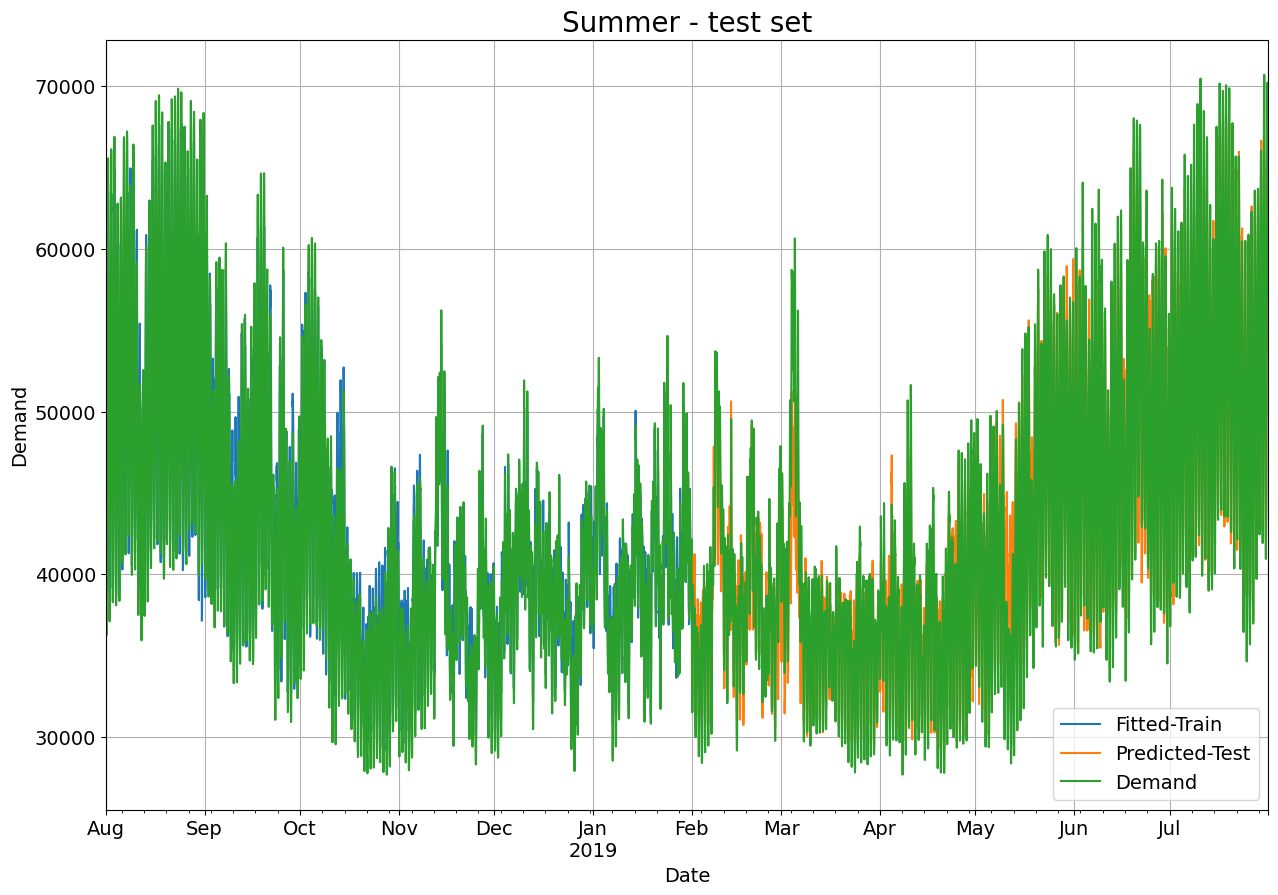

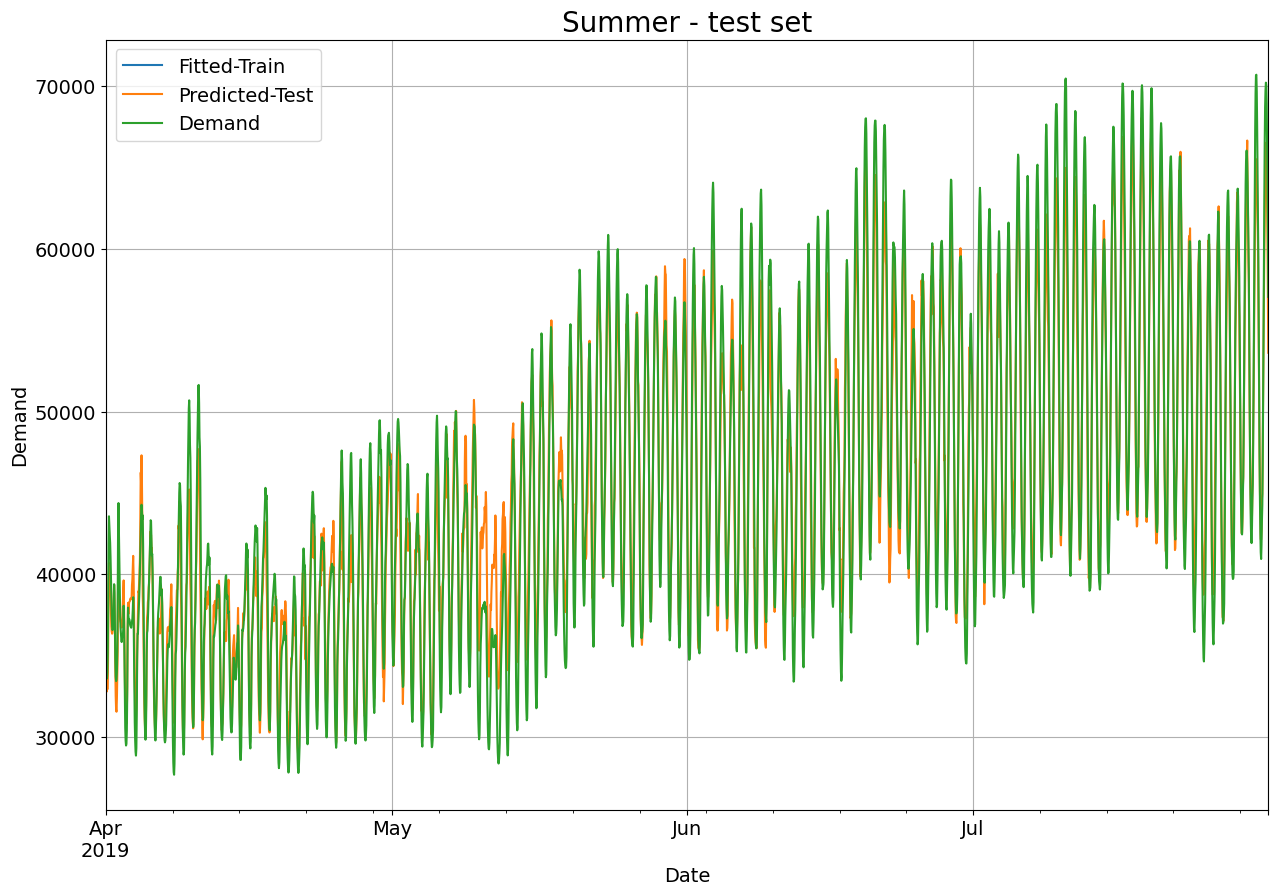

In [48]:
# Plot Fitted Data
DataWithPrediction_01[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                    .loc['2018-08':].plot()
                

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()



DataWithPrediction_01[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                    .loc['2019-04':].plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [43]:
print( CalculateR2andR2adj(y_Test_01, yhat_Test_ANN_01, X_Test_sld_01, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_01, yhat_Test_ANN_01),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_01, yhat_Test_ANN_01)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_01, yhat_Test_ANN_01)),2)}' )

R2: 0.9421
R2_adj: 0.941
(0.9421, 0.941)

MAE:  1700.72
MAPE: 3.95
RSME: 2266.21


In [44]:
###################
#%% test '02' model on winter time
###################

In [45]:
# Make prediction on test set
yhat_Test_ANN_02, X_Test_ANN_02 = \
     MakeTSforecast(X_Test_sld_02,\
                    Model = Final_Model_02,\
                    DependentVar = Dependent_Var,\
                    Intecept = False,\
                    LagsList = LagList,\
                    Scaler_y = scaler_y_02,\
                    Scaler_X = scaler_X_02,\
                    Test_or_Forecast = 'Test')

    
DataWithPrediction_02 =\
    MakeANNfinalData(Model = Final_Model_02,\
                     Train_X_Scaled = X_Train_sld_02,\
                     Val_X_Scaled = None,\
                     Scaler_y = scaler_y_02,\
                     MainDF = AnalysisData_02,\
                     yhat_Test_DF = yhat_Test_ANN_02,\
                     yhat_Forecast_DF = None)

1143/1143 [==============================] - 2s 1ms/step


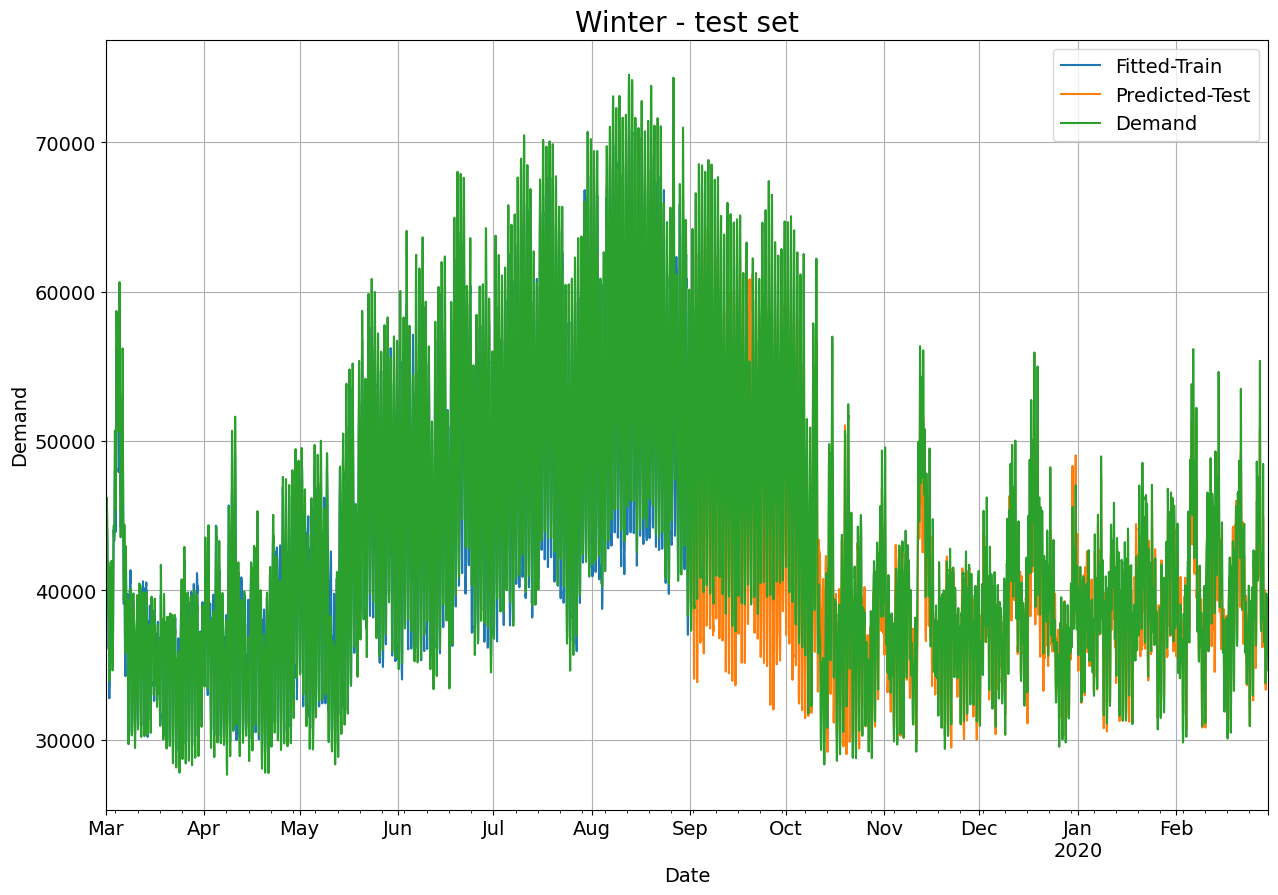

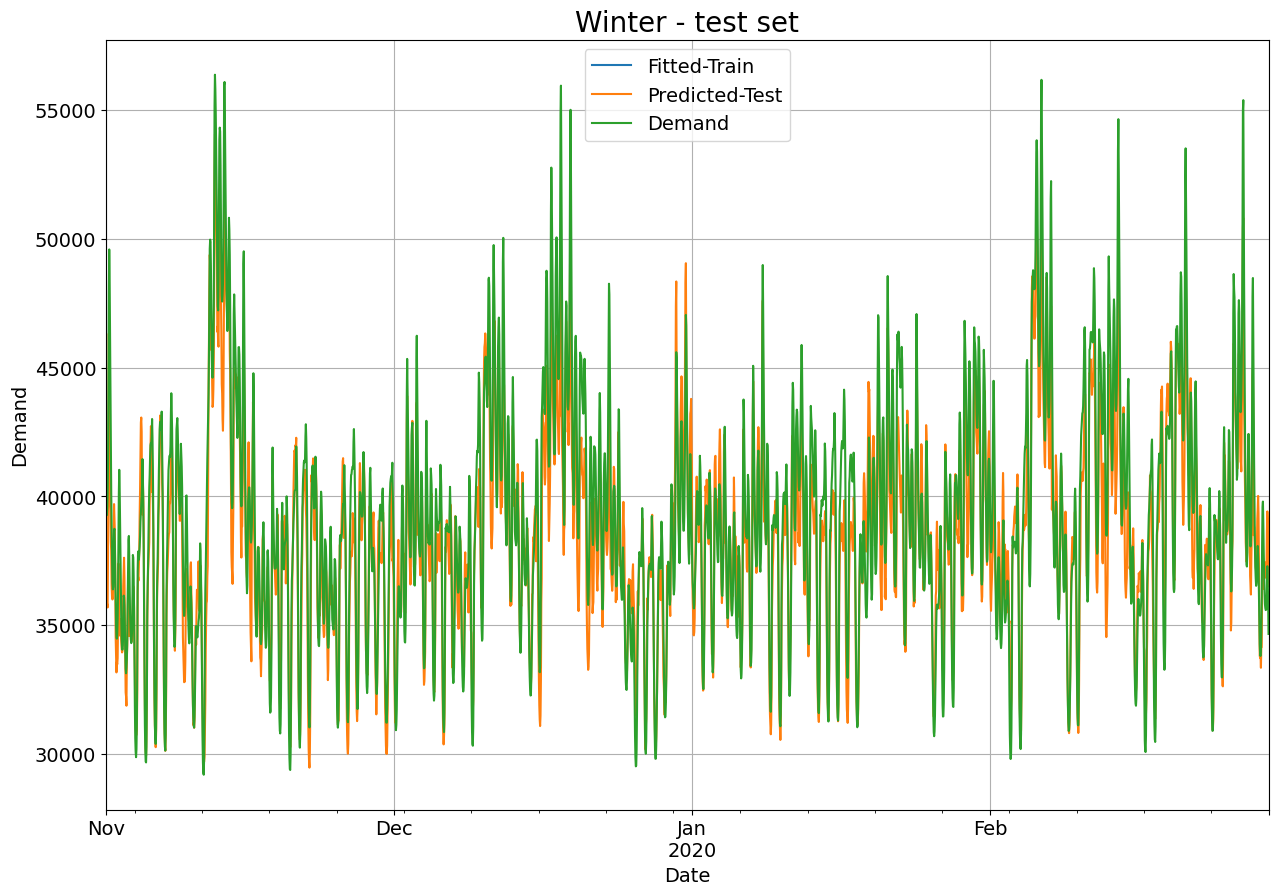

In [46]:
# Plot Fitted Data
DataWithPrediction_02[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                                .loc['2019-03':].plot()       
        

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()




DataWithPrediction_02[['Fitted-Train','Predicted-Test',Dependent_Var]]\
                    .loc['2019-11':].plot()


plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [47]:
print( CalculateR2andR2adj(y_Test_02, yhat_Test_ANN_02, X_Test_sld_02, const = False) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_02, yhat_Test_ANN_02),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_02, yhat_Test_ANN_02)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_02, yhat_Test_ANN_02)),2)}' )

R2: 0.8733
R2_adj: 0.8708
(0.8733, 0.8708)

MAE:  2071.88
MAPE: 4.66
RSME: 2777.5
